# Scraping Notícias

In [ ]:
# Importar bibliotecas
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='folhaES(RMGV)')

In [ ]:
# Scraping das notícias
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

linkMateria = []
tituloMateria = []
corpoMateria = [] 

for url in urls.url: 
  try:

    req = requests.get(url)
    soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")

    link = url
    titulo = soup.find('h2')

    d = soup.find('div', class_='col-12 col-sm-12 col-md-12 col-lg-9 col-xl-9 img100') 
    p = d.find_all('p')
    corpoMateria.append(p) 
    
    linkMateria.append(link)
    tituloMateria.append(titulo.text)

  except:
    pass

In [ ]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria, corpoMateria)), columns=['link','titulo','materia'])
df.head(3)

,link,titulo,materia
0,https://www.folhadoes.com/noticia/policia-espi...,Adolescente morre em pátio de delegacia após s...,"[[[<span>O</span>], adolescente Matheus Ribei..."
1,https://www.folhadoes.com/noticia/policia-espi...,Vizinhos espancam suspeito de estuprar menino ...,"[[[<span>V</span>], aldir Paulino da Silva, de..."
2,https://www.folhadoes.com/noticia/policia-espi...,Homem leva uma 'surra' após furtar posto de co...,"[[[<span>N</span>], a tarde desta sexta-feira ..."


In [ ]:
# Salvar o conteúdo em excel
df.to_excel('folhaES.xlsx')

# Mineração de Texto

In [2]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import pandas as pd

In [3]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Ler base
df = pd.read_excel('/content/folhaES.xlsx')

# Remover duplicados
df = df.drop_duplicates(subset=['link'], keep='first')

In [5]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/rmgvStopwords.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [6]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

# Funções

In [7]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transforma em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(mode = "RGBA", background_color=None,width=800, height=400, max_words=50).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

# Pré-processamento

In [8]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = limparTitulos(df['titulo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

In [9]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

# Tokenização e frequências

In [10]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(50)

,Termos,Frequência
10,homem,3
4,espancado,2
0,adolescente,1
25,populares,1
20,mulher,1
21,atravessava,1
22,faixa,1
23,acaba,1
24,linchado,1
26,assaltante,1


In [11]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(50)

,Termos,Frequência
5,delegacia,12
17,policia,11
43,policiais,8
73,casa,7
177,suspeito,7
128,bairro,7
289,luan,7
189,vitima,7
187,moradores,7
196,crianca,7


# Nuvem de palavras

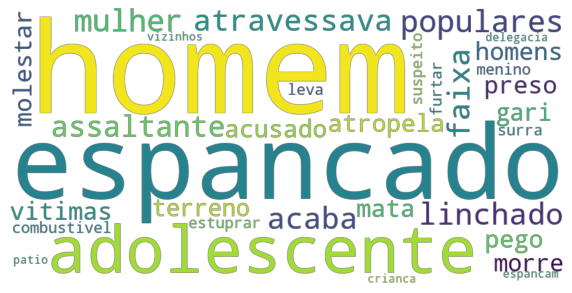

In [ ]:
gerarNuvem(frequenciaTitulo)

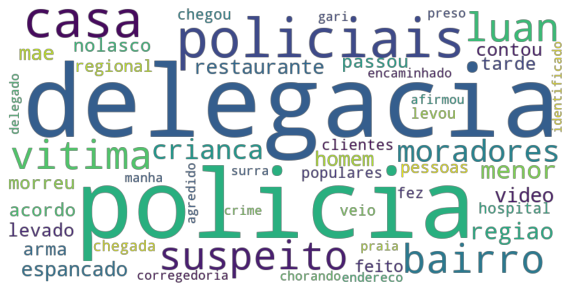

In [ ]:
gerarNuvem(frequenciaMateria)